# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('real_estate_data.csv', sep = '\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Предобработка данных

пропуски можно сразу заполнить в столбцах:

- is_apartment - пропуски можно заполнить значением False, скорее всего, если это апартаменты, то это указано, а если нет, то может быть не указано  
- balcony - можно заполнить значением 0, скорее всего, балкона в квартире нет               

нужно проверить есть ли закономерность в появлении пропусков:
- ceiling_height - почти 9 тыс пропусков
- kitchen_area - 2 тыс пропусков, возможно это студии

пропуски, которые невозможно заполнить:

- floors_total       
- living_area
- locality_name
- airports_nearest
- cityCenters_nearest   
- parks_around3000      
- parks_nearest         
- ponds_around3000      
- ponds_nearest         
- days_exposition  

In [3]:
df['is_apartment'].value_counts(dropna=False)

NaN      20924
False     2725
True        50
Name: is_apartment, dtype: int64

In [4]:
df['is_apartment'] = df['is_apartment'].fillna(value=False)
df['is_apartment'].value_counts(dropna=False)

False    23649
True        50
Name: is_apartment, dtype: int64

In [5]:
df['balcony'] = df['balcony'].fillna(value=0)
df['balcony'].value_counts(dropna=False)

0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

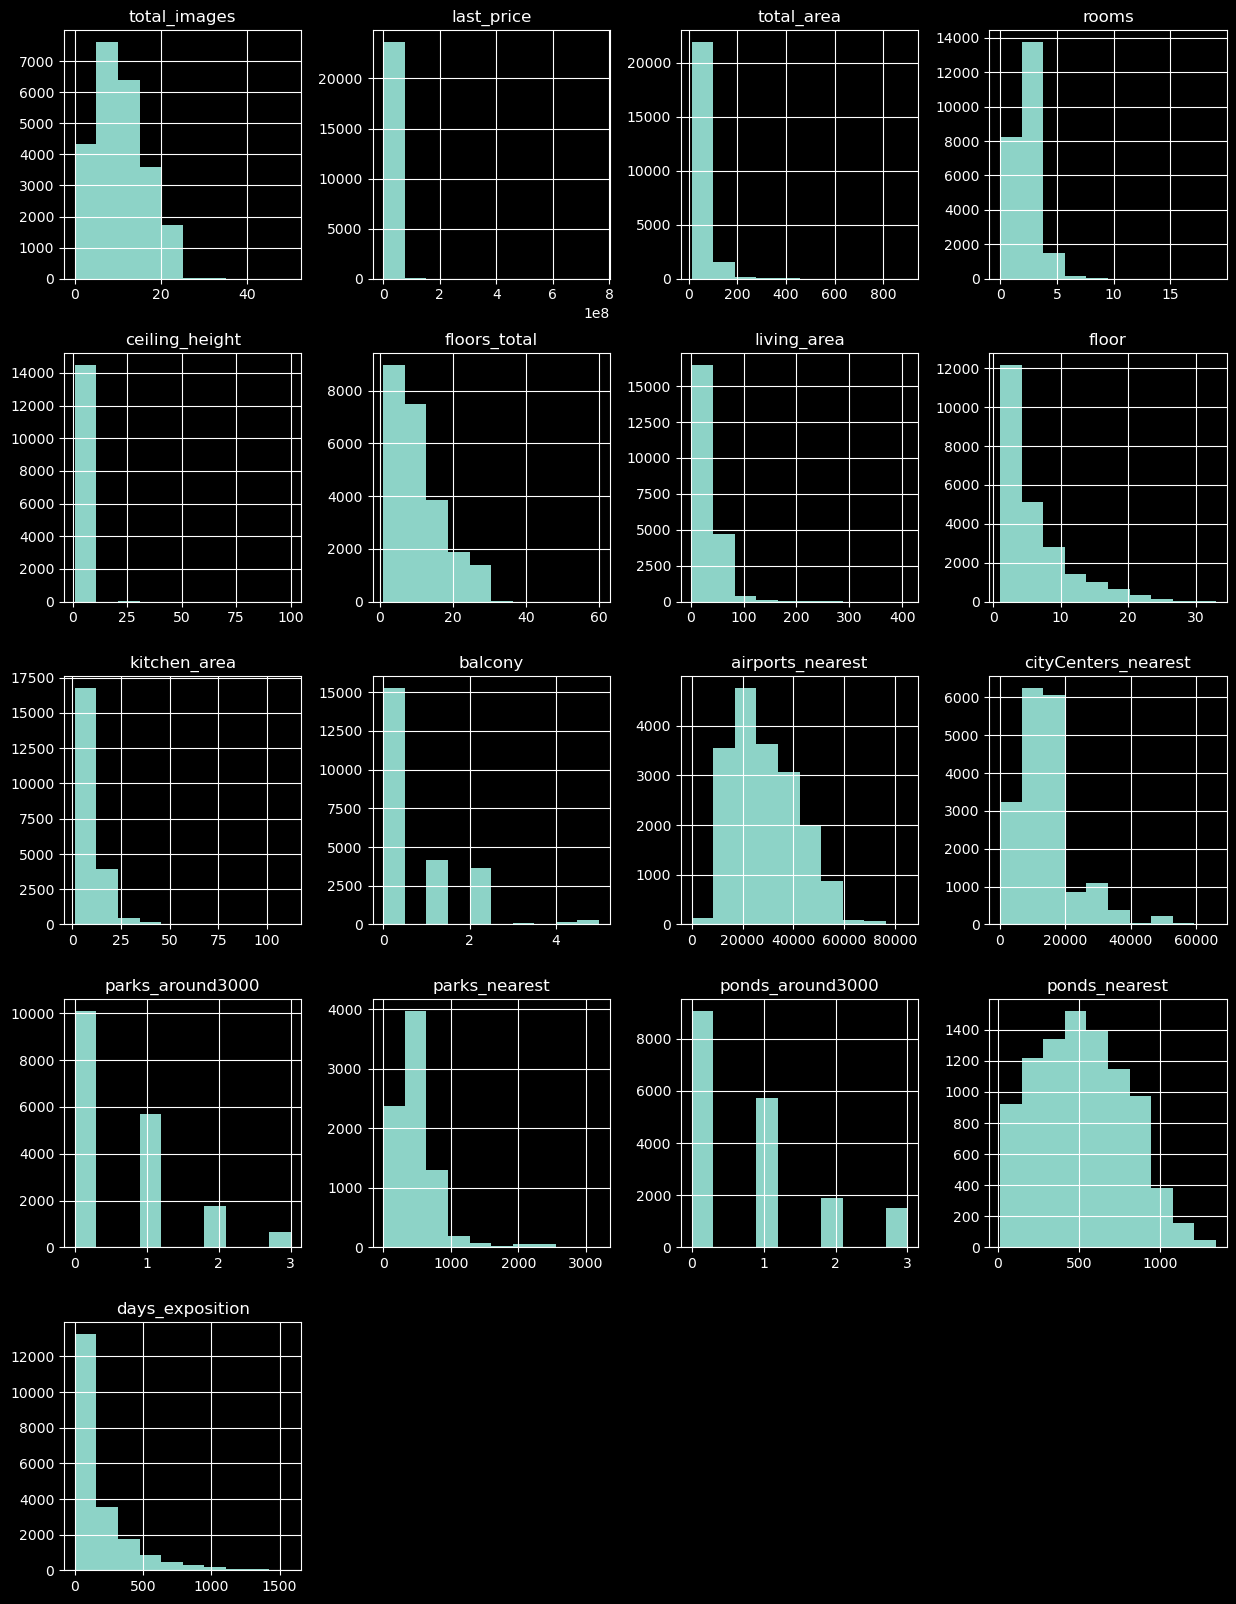

In [6]:
df.hist(figsize = (15, 20));

**Можно заметить, что в столбцах last_price, total_area, living_area, ceiling_height есть сильно выбивающиеся значения, поэтому нужно посмотреть список уникальных значений в каждом столбце**

In [7]:
df['last_price'].sort_values(ascending=False).head()

12971    763000000.0
19540    420000000.0
14706    401300000.0
1436     330000000.0
15651    300000000.0
Name: last_price, dtype: float64

почти 800 млн за самую дорогую квартиру, наверное реально

In [8]:
df['last_price'].sort_values(ascending=True).head()

8793      12190.0
17456    430000.0
14911    430000.0
16274    440000.0
17676    450000.0
Name: last_price, dtype: float64

а с минимальной стоимостью что-то не то, посмотрим, что там в других столбцах

In [9]:
df[df['last_price']== 12190]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,False,...,40.5,0.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


видимо запятая стоит не там, цена указана в млн, а не в тыс, заменим цену

In [10]:
df['last_price'] = df['last_price'].replace(12190, 12190000)

In [11]:
df[df['last_price'] == 12190000] #проверяем

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190000.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,False,...,40.5,0.0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
16579,19,12190000.0,100.0,2017-11-23T00:00:00,3,2.90,16.0,51.0,5,False,...,25.0,2.0,Санкт-Петербург,36765.0,11777.0,0.0,NaN,0.0,NaN,241.0


**опечатка устранена**

In [12]:
df['total_area'].sort_values(ascending=False).head()

19540    900.0
12859    631.2
3117     631.0
15651    618.0
5358     590.0
Name: total_area, dtype: float64

In [13]:
df[df['total_area'] == 900]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.8,25.0,409.7,25,False,...,112.0,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


In [14]:
df['total_area'].sort_values(ascending=True).head()

19904    12.0
17961    13.0
19546    13.0
19807    13.0
19558    13.2
Name: total_area, dtype: float64

**c общей площадью всё выглядит адекватно**

In [15]:
df['living_area'].sort_values(ascending=True).head()

21758    2.0
13915    2.0
23574    3.0
3242     3.0
17582    5.0
Name: living_area, dtype: float64

In [16]:
df.query('living_area<10')[['total_area', 'living_area']].sort_values('living_area', ascending=True)

,total_area,living_area
21758,23.00,2.0
13915,52.00,2.0
23574,139.00,3.0
3242,41.00,3.0
17582,22.00,5.0
21943,77.60,5.4
16431,31.00,6.0
19251,33.00,6.5
20994,50.60,8.0
23208,37.00,8.0


есть ошибки в данных, например, для строки 23574 в квартире площадью 139.00 жилая площадь не может быть 3.0, будем иметь в виду

<AxesSubplot:>

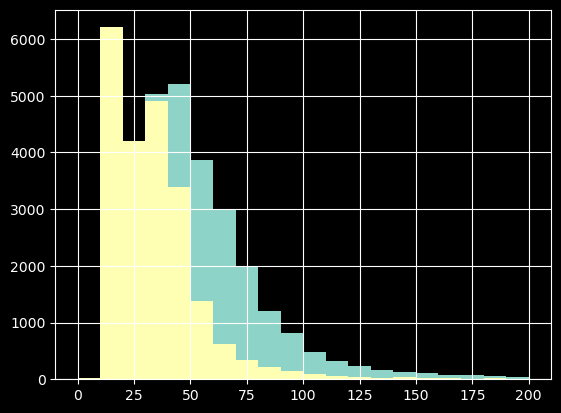

In [17]:
df['total_area'].hist(bins = 20, range = (0,200))
df['living_area'].hist(bins = 20, range = (0,200))

In [18]:
df[['total_area','living_area']].corr()

,total_area,living_area
total_area,1.000000,0.939537
living_area,0.939537,1.000000


**всё выглядит логично, жилая площадь хорошо коррелирует с общей площадью**

вернемся к kitchen_area, рассмотрим данные более подробно

In [19]:
df['kitchen_area'].value_counts('mean', dropna=False)

NaN      0.096122
6.00     0.054855
10.00    0.053251
8.00     0.046837
9.00     0.046458
           ...   
53.10    0.000042
12.56    0.000042
11.84    0.000042
13.27    0.000042
13.83    0.000042
Name: kitchen_area, Length: 972, dtype: float64

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

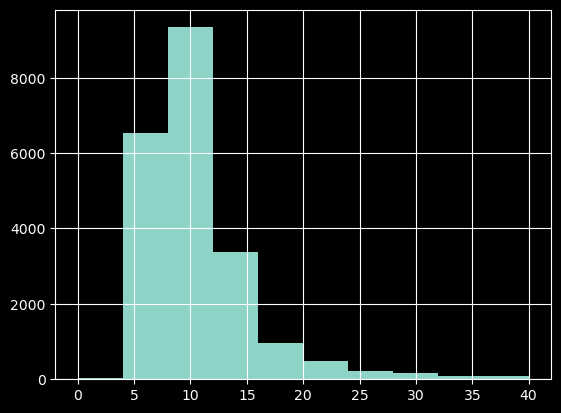

In [20]:
df['kitchen_area'].hist(bins = 10, range = (0,40))
df['kitchen_area'].describe()

очень много пропусков, попробуем заполнить их нулем

In [21]:
df[(df['kitchen_area'] == 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [22]:
df['kitchen_area_new'] = df['kitchen_area'].fillna(0)

df.loc[df['kitchen_area_new'] == 0].groupby('studio')['kitchen_area_new'].agg('count')

studio
False    2129
True      149
Name: kitchen_area_new, dtype: int64

**вывод: лишь небольшая часть пропусков в площади кухни связана с тем, что это студии**

In [23]:
df[['total_area','kitchen_area','kitchen_area_new']].corr()

,total_area,kitchen_area,kitchen_area_new
total_area,1.000000,0.609121,0.51427
kitchen_area,0.609121,1.000000,1.00000
kitchen_area_new,0.514270,1.000000,1.00000


**вывод: исходный столбец kitchen_area лучше коррелирует с данными total_area,  вдальнейшем для анализа можно использовать исходный столбец**

посмотрим, что с высотой потолков

In [24]:
df['ceiling_height'].value_counts('mean', dropna=False)

NaN     0.387991
2.50    0.148318
2.60    0.069454
2.70    0.066416
3.00    0.046922
          ...   
5.00    0.000042
2.20    0.000042
4.15    0.000042
3.93    0.000042
3.59    0.000042
Name: ceiling_height, Length: 184, dtype: float64

в 38% данных пропущено значение высоты потолков нужно проверить полученные данные на предмет выбросов

In [25]:
df['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

есть слишком маленькие и слишком большие значения высоты потолков, узнаем их количество

In [26]:
df[df['ceiling_height'] < 2.4].sort_values('ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_area_new
22590,16,6000000.0,55.00,2018-10-31T00:00:00,2,1.00,12.0,32.400000,7,False,...,0.0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0,10.00
5712,5,1500000.0,42.80,2017-08-14T00:00:00,2,1.20,2.0,27.500000,1,False,...,0.0,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0,5.20
16934,5,4100000.0,40.00,2017-10-17T00:00:00,1,1.75,37.0,17.400000,5,False,...,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0,8.34
16446,6,12300000.0,88.30,2019-03-12T00:00:00,3,2.00,5.0,63.900000,2,False,...,0.0,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN,12.00
552,11,2999000.0,33.50,2017-03-30T00:00:00,1,2.00,15.0,17.500000,6,False,...,0.0,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0,6.50
2572,4,2400000.0,62.00,2018-12-27T00:00:00,3,2.00,5.0,40.000000,4,False,...,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00
4212,1,2120000.0,35.43,2017-12-18T00:00:00,1,2.00,18.0,16.600000,9,False,...,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0,8.80
20520,9,3600000.0,38.00,2018-07-05T00:00:00,1,2.00,12.0,15.000000,9,False,...,1.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,62.0,11.80
5850,9,1650000.0,35.50,2018-05-29T00:00:00,1,2.00,5.0,NaN,5,False,...,0.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.00
11352,4,3300000.0,36.00,2017-06-18T00:00:00,1,2.00,17.0,15.200000,12,False,...,0.0,посёлок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0,10.10


**видно, что есть явные ошибки, но их не так много**

In [27]:
df[df['ceiling_height'] > 6].sort_values('ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_area_new
3474,3,1400000.0,30.0,2018-03-16T00:00:00,1,8.0,5.0,15.3,2,False,...,0.0,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0,7.3
17442,0,5350000.0,54.0,2015-06-16T00:00:00,2,8.0,5.0,29.0,2,False,...,1.0,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0,0.0
15743,14,5600000.0,67.0,2016-11-11T00:00:00,3,8.0,16.0,41.0,1,False,...,0.0,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0,8.0
5863,20,5650000.0,45.0,2018-08-15T00:00:00,1,8.3,16.0,19.3,14,False,...,1.0,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0,8.3
22309,20,5300000.0,45.0,2017-09-30T00:00:00,1,10.3,16.0,15.5,15,False,...,0.0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0,0.0
15061,19,5600000.0,56.4,2018-05-11T00:00:00,2,14.0,14.0,32.4,5,False,...,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0,9.1
17496,15,6700000.0,92.9,2019-02-19T00:00:00,3,20.0,17.0,53.2,14,False,...,5.0,Санкт-Петербург,16295.0,15092.0,1.0,967.0,0.0,NaN,NaN,12.0
20507,12,5950000.0,60.0,2018-02-19T00:00:00,2,22.6,14.0,35.0,11,False,...,1.0,Санкт-Петербург,27028.0,12570.0,0.0,NaN,0.0,NaN,40.0,13.0
5076,0,3850000.0,30.5,2018-10-03T00:00:00,1,24.0,5.0,19.5,1,True,...,0.0,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0,5.5
355,17,3600000.0,55.2,2018-07-12T00:00:00,2,25.0,5.0,32.0,2,False,...,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0,0.0


**также есть единичные выбросы, заменим явные ошибки в данных**

In [28]:
df['ceiling_height'] = df['ceiling_height'].replace(20, 2.0).replace(22.6, 2.26).replace(24., 2.4).replace(25., 2.5).replace(26., 2.6).replace(27., 2.7).replace(27.5, 2.75).replace(32., 3.2)

df['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.26,   2.3 ,
         2.34,   2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,
         2.51,   2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,
         2.59,   2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,
         2.67,   2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,
         2.75,   2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,
         2.83,   2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,
         2.91,   2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,
         2.99,   3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,
         3.07,   3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,
         3.15,   3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,
         3.24,   3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,
         3.32,   3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,
         3.4 ,   3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,
      

In [29]:
df['ceiling_height'].median()

2.65

заполним пропуски медианным значением и удалим выбросы

In [30]:
df['ceiling_height'] = df['ceiling_height'].fillna(value=df['ceiling_height'].median())
df = df.loc[(df['ceiling_height'] < 6) & (df['ceiling_height'] > 2)]

df['ceiling_height'].sort_values().unique()

array([2.2 , 2.25, 2.26, 2.3 , 2.34, 2.4 , 2.45, 2.46, 2.47, 2.48, 2.49,
       2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 ,
       2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71,
       2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82,
       2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93,
       2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04,
       3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15,
       3.16, 3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27,
       3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38,
       3.39, 3.4 , 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 ,
       3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62,
       3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 ,
       3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95, 3.98,
       4.  , 4.06, 4.1 , 4.14, 4.15, 4.19, 4.2 , 4.

**данные высоты потолков проанализированы, пропуски заполнены медианным значением, выбросы удалены**

обработаем дубликаты в названиях населенных пунктов

In [31]:
unique_locality_name = df['locality_name'].sort_values().unique()

for name in unique_locality_name:
    print(name)

Бокситогорск
Волосово
Волхов
Всеволожск
Выборг
Высоцк
Гатчина
Зеленогорск
Ивангород
Каменногорск
Кингисепп
Кириши
Кировск
Колпино
Коммунар
Красное Село
Кронштадт
Кудрово
Лодейное Поле
Ломоносов
Луга
Любань
Мурино
Никольское
Новая Ладога
Отрадное
Павловск
Петергоф
Пикалёво
Подпорожье
Приморск
Приозерск
Пушкин
Санкт-Петербург
Светогорск
Сертолово
Сестрорецк
Сланцы
Сосновый Бор
Сясьстрой
Тихвин
Тосно
Шлиссельбург
городской поселок Большая Ижора
городской поселок Янино-1
городской посёлок Будогощь
городской посёлок Виллози
городской посёлок Лесогорский
городской посёлок Мга
городской посёлок Назия
городской посёлок Новоселье
городской посёлок Павлово
городской посёлок Рощино
городской посёлок Свирьстрой
городской посёлок Советский
городской посёлок Фёдоровское
городской посёлок Янино-1
деревня Агалатово
деревня Аро
деревня Батово
деревня Бегуницы
деревня Белогорка
деревня Большая Вруда
деревня Большая Пустомержа
деревня Большие Колпаны
деревня Большое Рейзино
деревня Большой Сабск
деревня 

**в locality_name очень много дубликатов
переведем данные в строковый тип и заменим 'поселок' на 'посёлок'**

In [32]:
df['locality_name'] = df['locality_name'].astype(str)

In [33]:
for name in df['locality_name']:
    if 'поселок' in name:
        locality_list = name.split(' ')
        for value in locality_list:
            if value == 'поселок':
                p_index = locality_list.index(value)
                locality_list[p_index] = 'посёлок'
                new_name = ' '.join(locality_list)
                df['locality_name'] = df['locality_name'].replace(name, new_name)

unique_locality_name = df['locality_name'].sort_values().unique()
for name in unique_locality_name:
    print(name)

nan
Бокситогорск
Волосово
Волхов
Всеволожск
Выборг
Высоцк
Гатчина
Зеленогорск
Ивангород
Каменногорск
Кингисепп
Кириши
Кировск
Колпино
Коммунар
Красное Село
Кронштадт
Кудрово
Лодейное Поле
Ломоносов
Луга
Любань
Мурино
Никольское
Новая Ладога
Отрадное
Павловск
Петергоф
Пикалёво
Подпорожье
Приморск
Приозерск
Пушкин
Санкт-Петербург
Светогорск
Сертолово
Сестрорецк
Сланцы
Сосновый Бор
Сясьстрой
Тихвин
Тосно
Шлиссельбург
городской посёлок Большая Ижора
городской посёлок Будогощь
городской посёлок Виллози
городской посёлок Лесогорский
городской посёлок Мга
городской посёлок Назия
городской посёлок Новоселье
городской посёлок Павлово
городской посёлок Рощино
городской посёлок Свирьстрой
городской посёлок Советский
городской посёлок Фёдоровское
городской посёлок Янино-1
деревня Агалатово
деревня Аро
деревня Батово
деревня Бегуницы
деревня Белогорка
деревня Большая Вруда
деревня Большая Пустомержа
деревня Большие Колпаны
деревня Большое Рейзино
деревня Большой Сабск
деревня Бор
деревня Борисова Г

заменим "городской посёлок" на "посёлок городского типа", для этого сначала выведем эти строки на экран

In [34]:
for name in unique_locality_name:
    if 'городской посёлок' in name or 'посёлок городского типа' in name:
        print(name)

городской посёлок Большая Ижора
городской посёлок Будогощь
городской посёлок Виллози
городской посёлок Лесогорский
городской посёлок Мга
городской посёлок Назия
городской посёлок Новоселье
городской посёлок Павлово
городской посёлок Рощино
городской посёлок Свирьстрой
городской посёлок Советский
городской посёлок Фёдоровское
городской посёлок Янино-1
посёлок городского типа Большая Ижора
посёлок городского типа Важины
посёлок городского типа Вознесенье
посёлок городского типа Вырица
посёлок городского типа Дружная Горка
посёлок городского типа Дубровка
посёлок городского типа Ефимовский
посёлок городского типа Кондратьево
посёлок городского типа Красный Бор
посёлок городского типа Кузнечное
посёлок городского типа Кузьмоловский
посёлок городского типа Лебяжье
посёлок городского типа Лесогорский
посёлок городского типа Мга
посёлок городского типа Назия
посёлок городского типа Никольский
посёлок городского типа Павлово
посёлок городского типа Приладожский
посёлок городского типа Рахья
по

несколько замен произведём вручную:

In [35]:
df['locality_name'] = df['locality_name'].replace('городской посёлок Большая Ижора', 'посёлок городского типа Большая Ижора')
df['locality_name'] = df['locality_name'].replace('городской посёлок Мга', 'посёлок городского типа Мга')
df['locality_name'] = df['locality_name'].replace('городской посёлок Назия', 'посёлок городского типа Назия')
df['locality_name'] = df['locality_name'].replace('городской посёлок Павлово', 'посёлок городского типа Павлово')
df['locality_name'] = df['locality_name'].replace('городской посёлок Рощино', 'посёлок городского типа Рощино')
df['locality_name'] = df['locality_name'].replace('городской посёлок Советский', 'посёлок городского типа Советский')
df['locality_name'] = df['locality_name'].replace('посёлок Рябово', 'посёлок городского типа Рябово')
df['locality_name'] = df['locality_name'].replace('городской посёлок Будогощь', 'посёлок городского типа Будогощь')
df['locality_name'] = df['locality_name'].replace('городской посёлок Виллози', 'посёлок городского типа Виллози')
df['locality_name'] = df['locality_name'].replace('городской посёлок Лесогорский', 'посёлок городского типа Лесогорский')
df['locality_name'] = df['locality_name'].replace('городской посёлок Новоселье', 'посёлок городского типа Новоселье')
df['locality_name'] = df['locality_name'].replace('городской посёлок Свирьстрой', 'посёлок городского типа Свирьстрой')
df['locality_name'] = df['locality_name'].replace('городской посёлок Фёдоровское', 'посёлок городского типа Фёдоровское')
df['locality_name'] = df['locality_name'].replace('городской посёлок Янино-1', 'посёлок городского типа Янино-1')
df['locality_name'] = df['locality_name'].replace('посёлок при железнодорожной станции Вещево', 'посёлок станции Вещево')
df['locality_name'] = df['locality_name'].replace('посёлок при железнодорожной станции Приветнинское', 'посёлок станции Приветнинское')

unique_locality_name = df['locality_name'].sort_values().unique()
for name in unique_locality_name:
    print(name)

nan
Бокситогорск
Волосово
Волхов
Всеволожск
Выборг
Высоцк
Гатчина
Зеленогорск
Ивангород
Каменногорск
Кингисепп
Кириши
Кировск
Колпино
Коммунар
Красное Село
Кронштадт
Кудрово
Лодейное Поле
Ломоносов
Луга
Любань
Мурино
Никольское
Новая Ладога
Отрадное
Павловск
Петергоф
Пикалёво
Подпорожье
Приморск
Приозерск
Пушкин
Санкт-Петербург
Светогорск
Сертолово
Сестрорецк
Сланцы
Сосновый Бор
Сясьстрой
Тихвин
Тосно
Шлиссельбург
деревня Агалатово
деревня Аро
деревня Батово
деревня Бегуницы
деревня Белогорка
деревня Большая Вруда
деревня Большая Пустомержа
деревня Большие Колпаны
деревня Большое Рейзино
деревня Большой Сабск
деревня Бор
деревня Борисова Грива
деревня Ваганово
деревня Вартемяги
деревня Вахнова Кара
деревня Выскатка
деревня Гарболово
деревня Глинка
деревня Горбунки
деревня Гостилицы
деревня Заклинье
деревня Заневка
деревня Зимитицы
деревня Извара
деревня Иссад
деревня Калитино
деревня Кальтино
деревня Камышовка
деревня Каськово
деревня Келози
деревня Кипень
деревня Кисельня
деревня Колт

**неявные дубликаты найдены и устранены**

In [36]:
df.duplicated(subset=None, keep='first').value_counts()

False    23676
dtype: int64

In [37]:
df['balcony'] = df['balcony'].astype(int)
df['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

In [38]:
df['floors_total'] = df['floors_total'].astype(int, errors='ignore')
t=df['floors_total'].sort_values().unique()
for value in t:
    print(value)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
33.0
34.0
35.0
36.0
52.0
60.0
nan


In [39]:
df['floors_total'].value_counts(dropna=False)

5.0     5780
9.0     3760
16.0    1373
12.0    1360
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     831
3.0      668
7.0      591
14.0     552
18.0     504
24.0     469
8.0      390
2.0      381
15.0     364
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
NaN       86
1.0       25
35.0      24
28.0      21
36.0       3
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
Name: floors_total, dtype: int64

In [40]:
df['floors_total'].info()

<class 'pandas.core.series.Series'>
Int64Index: 23676 entries, 0 to 23698
Series name: floors_total
Non-Null Count  Dtype  
--------------  -----  
23590 non-null  float64
dtypes: float64(1)
memory usage: 369.9 KB


### Посчитайте и добавьте в таблицу новые столбцы

посчитаем цену одного квадратного метра

In [41]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'kitchen_area_new'],
      dtype='object')

In [42]:
df['sqm_price']=df['last_price']/df['total_area']
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_area_new,sqm_price
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,25.00,120370.370370
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,11.00,82920.792079
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,8.30,92785.714286
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,False,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,0.00,408176.100629
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,41.00,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,...,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,13.83,72490.845228
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.0,4,False,...,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,8.50,52542.372881
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.7,1,False,...,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,44091.710758
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,False,...,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,23.30,149511.400651


**новый столбец добавлен в датафрейм**

добавим день недели, месяц и год публикации объявления, но сначала переведём данные в нужный вид

In [43]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_area_new,sqm_price,weekday_exposition,month_exposition,year_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,25.00,120370.370370,3,3,2019
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,0.0,NaN,0.0,NaN,81.0,11.00,82920.792079,1,12,2018
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,8.30,92785.714286,3,8,2015
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,NaN,9,False,...,2.0,84.0,3.0,234.0,424.0,0.00,408176.100629,4,7,2015
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,2.0,112.0,1.0,48.0,121.0,41.00,100000.000000,1,6,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,1.0,796.0,3.0,381.0,NaN,13.83,72490.845228,1,3,2017
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.0,4,False,...,NaN,NaN,NaN,NaN,45.0,8.50,52542.372881,0,1,2018
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.7,1,False,...,NaN,NaN,NaN,NaN,NaN,0.00,44091.710758,6,2,2018
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,...,2.0,173.0,3.0,196.0,602.0,23.30,149511.400651,1,3,2017


**новые столбцы добавлены в датафрейм**

добавим тип этажа квартиры (значения — «первый», «последний», «другой»)

In [44]:
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
kitchen_area_new               float64
sqm_price                      float64
weekday_exposition               int64
month_exposition         

In [45]:
def floor_type(line):
    if line['floor'] == 1:
        return 'первый'
    if line['floor'] == line['floors_total']:
        return 'последний'
    return 'другой'

In [46]:
df['floor_type'] = df.apply(floor_type, axis=1)

df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_area_new,sqm_price,weekday_exposition,month_exposition,year_exposition,floor_type
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,25.00,120370.370370,3,3,2019,другой
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,NaN,0.0,NaN,81.0,11.00,82920.792079,1,12,2018,первый
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,8.30,92785.714286,3,8,2015,другой
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,0.00,408176.100629,4,7,2015,другой
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,41.00,100000.000000,1,6,2018,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,796.0,3.0,381.0,NaN,13.83,72490.845228,1,3,2017,другой
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.0,4,False,...,NaN,NaN,NaN,45.0,8.50,52542.372881,0,1,2018,другой
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.7,1,False,...,NaN,NaN,NaN,NaN,0.00,44091.710758,6,2,2018,первый
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,...,173.0,3.0,196.0,602.0,23.30,149511.400651,1,3,2017,другой


**в датафрейм добавлен новый столбец с категорией этажа**

добавим расстояние до центра города в километрах


In [47]:
df['cityCenters_nearest_km'] = round(df['cityCenters_nearest']/1000)
df[['cityCenters_nearest','cityCenters_nearest_km']].head()

,cityCenters_nearest,cityCenters_nearest_km
0,16028.0,16.0
1,18603.0,19.0
2,13933.0,14.0
3,6800.0,7.0
4,8098.0,8.0


**в датафрейм добавлен новый столбец с расстоянием до центра в км, значения округлены до км**

### Проведите исследовательский анализ данных

In [48]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'kitchen_area_new', 'sqm_price',
       'weekday_exposition', 'month_exposition', 'year_exposition',
       'floor_type', 'cityCenters_nearest_km'],
      dtype='object')

count    23676.000000
mean        60.354395
std         35.656115
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

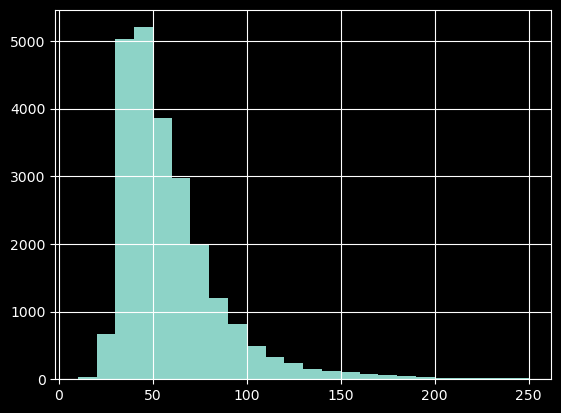

In [49]:
df['total_area'].hist(bins = 24, range = (10,250))
df['total_area'].describe()

<AxesSubplot:>

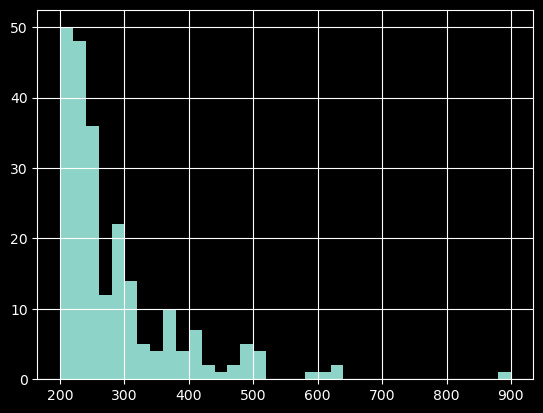

In [50]:
df['total_area'].hist(bins = 35, range = (200,900))

большинство квартир имеют площадь 40-50 кв.м, также есть очень большие квартиры (более 200 кв.м), таких очень небольшое количество

count    21775.000000
mean        34.459066
std         22.022673
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

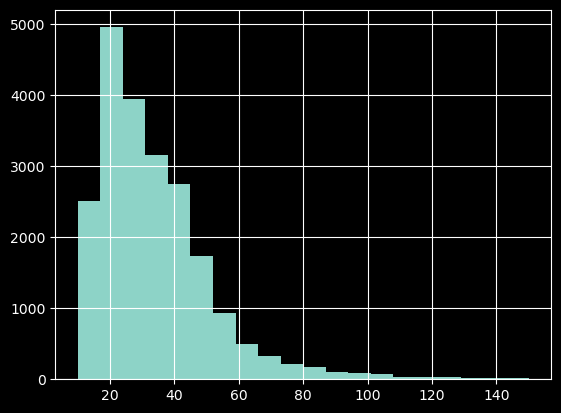

In [51]:
df['living_area'].hist(bins = 20, range = (10,150))
df['living_area'].describe()

<AxesSubplot:>

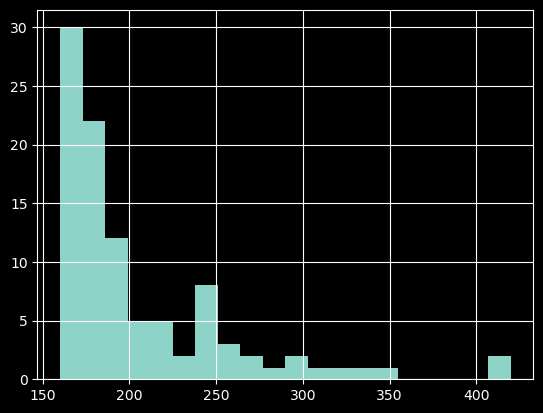

In [52]:
df['living_area'].hist(bins = 20, range = (160,420))

count    21402.000000
mean        10.571152
std          5.907376
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

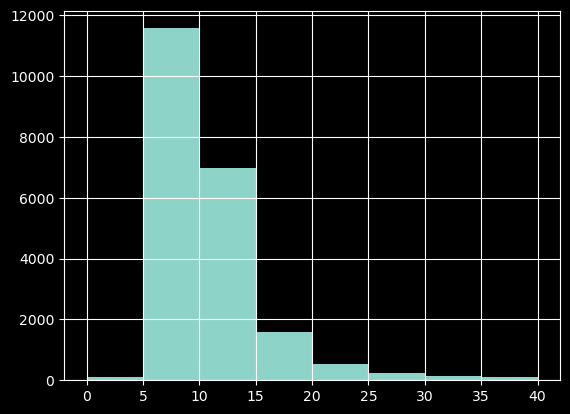

In [53]:
df['kitchen_area'].hist(bins = 8, range = (0,40))
df['kitchen_area'].describe()

In [54]:
df[['total_area','living_area','kitchen_area']].corr()

,total_area,living_area,kitchen_area
total_area,1.000000,0.939539,0.609190
living_area,0.939539,1.000000,0.428767
kitchen_area,0.609190,0.428767,1.000000


наблюдается высокая корреляция между жилой площадью и общей площадью, также есть корреляция между площадью кухни и общей площадью и более слабая корреляция между площадью кухни и жилой площадью

count    2.367600e+04
mean     6.539220e+06
std      1.086706e+07
min      4.300000e+05
25%      3.411750e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

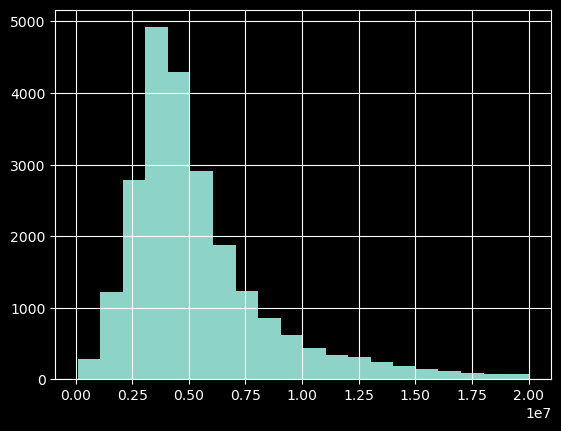

In [55]:
df['last_price'].hist(bins = 20, range = (1e+5, 2e+7))
df['last_price'].describe()

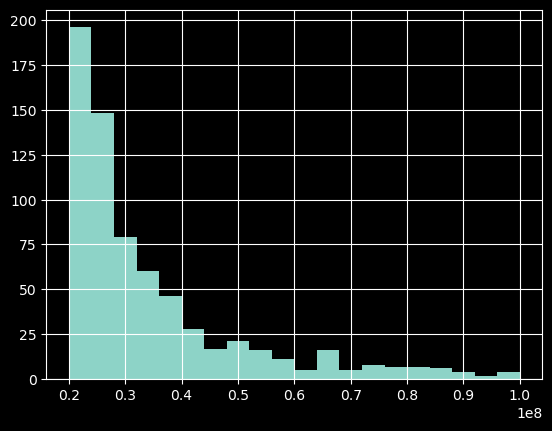

In [56]:
df['last_price'].hist(bins = 20, range = (2e+7, 1e+8));

большинство объектов недвижимости имеют стоимость до 20 млн р.

In [57]:
df['rooms'].describe()

count    23676.000000
mean         2.070873
std          1.078524
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

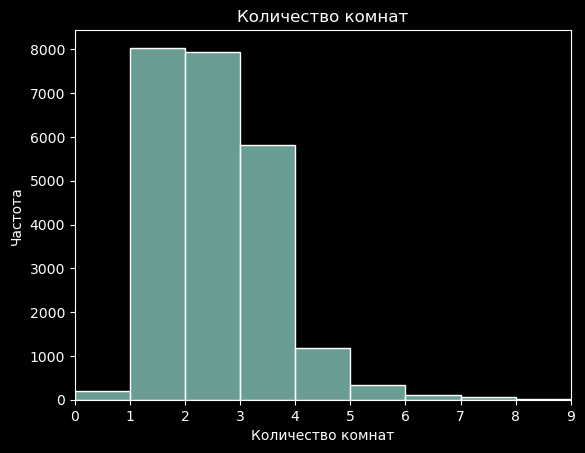

In [58]:
sns.histplot(df['rooms'], bins=19)
plt.xlim(0,9)
plt.title('Количество комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Частота')
plt.show()

большинство квартир 1-3 комнатные

count    23676.000000
mean         2.697095
std          0.219631
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.800000
Name: ceiling_height, dtype: float64

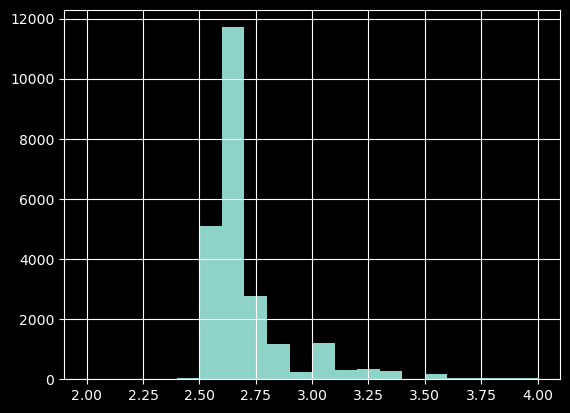

In [59]:
df['ceiling_height'].hist(bins = 20, range = (2, 4))
df['ceiling_height'].describe()

большинство квартир с высотой потолков от 2.5 до 3.1 м

count    23676.000000
mean         5.892169
std          4.885778
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

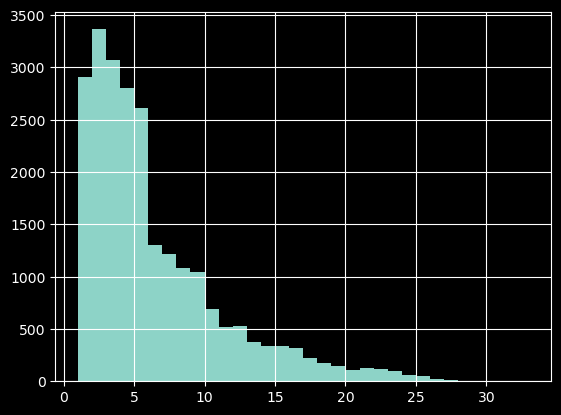

In [60]:
df['floor'].hist(bins = 32, range = (1,33))
df['floor'].describe()

очень много квартир на 1-6 этажах, также есть группа с большим количеством объявлений на 7-10 этажах, начиная с 11 количество объявлений плавно убывает

count    23590.000000
mean        10.673633
std          6.595989
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

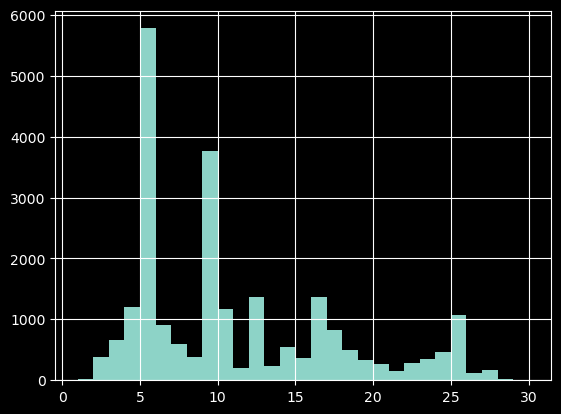

In [61]:
df['floors_total'].hist(bins = 29, range = (1,30))
df['floors_total'].describe()

большое количество домов 6-этажные, это коррелирует с тем, что большинство квартир в объявлниях на 1-6 этажах,  
также много 9-этажных домов, это коррелирует с большим количеством объявлений на 7-9 этажах

In [62]:
df[['floor','floors_total']].corr()

,floor,floors_total
floor,1.000000,0.678301
floors_total,0.678301,1.000000


есть корреляция с этажностью домов и этажом квартиры в объявлении

count      23676
unique         3
top       другой
freq       17431
Name: floor_type, dtype: object

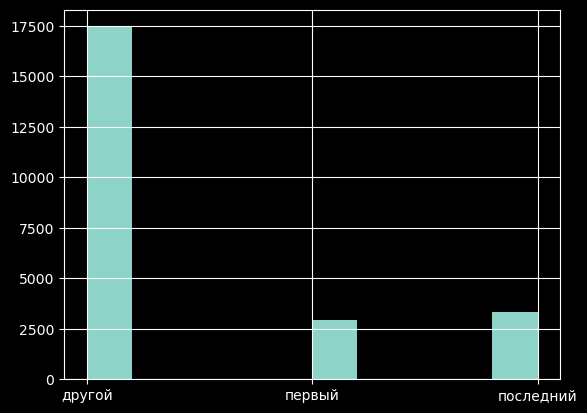

In [63]:
df['floor_type'].hist()
df['floor_type'].describe()

большинство квартир не на первом и не на последнем этажах

count    18167.000000
mean     14191.224913
std       8609.611621
min        181.000000
25%       9238.000000
50%      13099.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

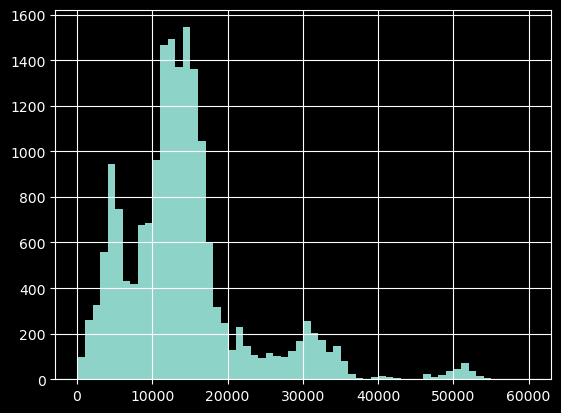

In [64]:
df['cityCenters_nearest'].hist(bins = 60, range = (100,60000))
df['cityCenters_nearest'].describe()

по гистограмме видно, что число предложений сначала растет с увеличением расстояния до центра и достигает максимума при 5 км, далее идёт спад до 7-8 км (скорее всего, примерно на этом расстоянии располагаются пром.зоны), далее идёт рост (советская многоэтажная застройка,переходящая в многоэтажные новостройки), также наблюдается пик на расттоянии 30 км, это уже предложения за КАДом - города и новостройки в Лен. области. Также есть пик после 50 км. можно предположить, что это дачи и загородные дома

count    18144.000000
mean     28795.058477
std      12633.264354
min          0.000000
25%      18584.250000
50%      26726.000000
75%      37278.750000
max      84869.000000
Name: airports_nearest, dtype: float64

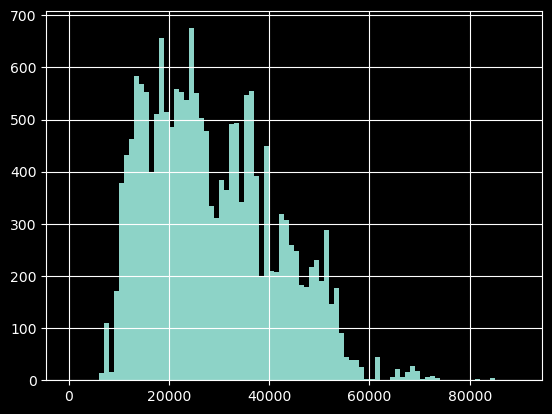

In [65]:
df['airports_nearest'].hist(bins = 90, range = (0,90000))
df['airports_nearest'].describe()

в Петербурге только один аэропорт и ехать до него почти всем далеко

count    8071.000000
mean      490.768430
std       342.415081
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

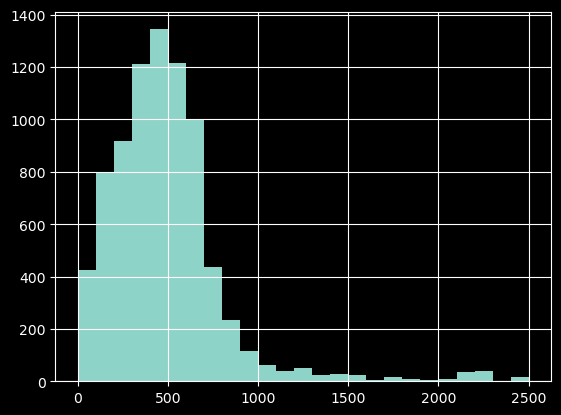

In [66]:
df['parks_nearest'].hist(bins = 25, range = (0,2500))
df['parks_nearest'].describe()

в большинстве случаев расстояние до ближайшего парка менее 1000 м

count    23676.000000
mean         2.569268
std          1.788989
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday_exposition, dtype: float64

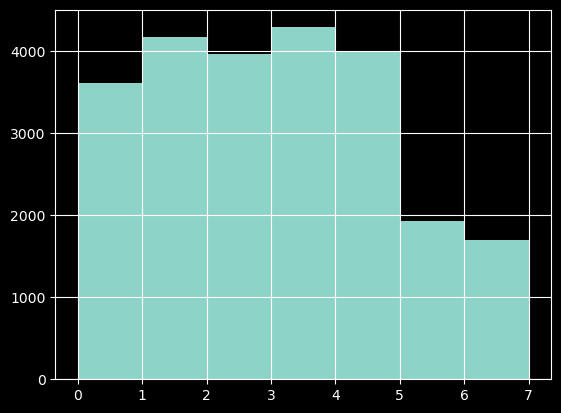

In [67]:
df['weekday_exposition'].hist(bins = 7, range = (0,7))
df['weekday_exposition'].describe()

на выходных объявлений выкладывается меньше всего, больше всего - в четверг и во вторник

count    23676.000000
mean         6.399434
std          3.491886
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

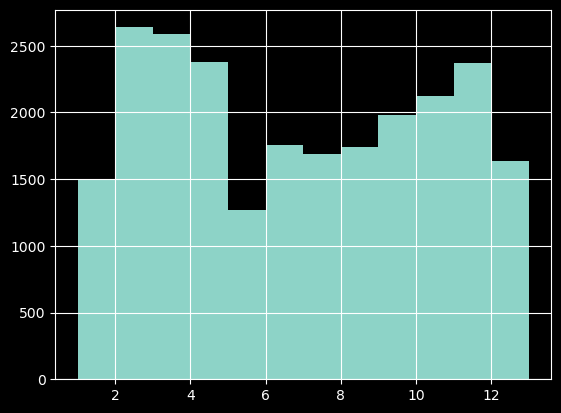

In [68]:
df['month_exposition'].hist(bins = 12, range = (1,13))
df['month_exposition'].describe()

февраль, март и апрель - самые популярны месяцы размещения объявлений
в мае просадка, в июне оживление и рост до ноября, в декабре и январе спад

count    20499.000000
mean       180.910093
std        219.782944
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

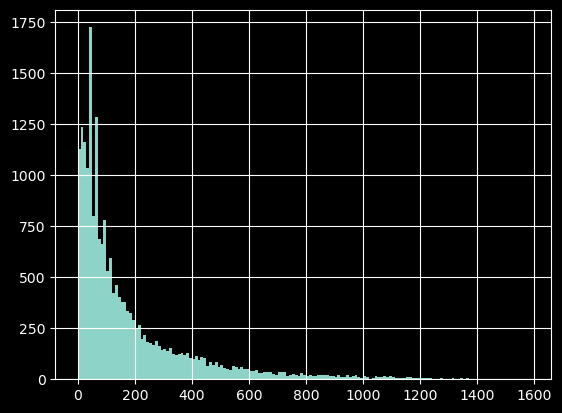

In [69]:
df['days_exposition'].hist(bins = 158, range = (0,1580))
df['days_exposition'].describe()

<AxesSubplot:>

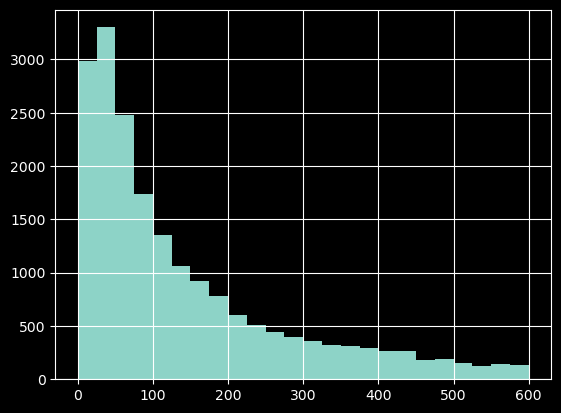

In [70]:
df['days_exposition'].hist(bins = 24, range = (0,600));

в среднем 180 дней висит объявление, медианное значение - 95 дней,
быстрыми продажами можно назвать продажи в течение 50 дней,
необычно долгие продажи - это продажи дольше 1000 дней

In [71]:
df['last_price'].describe()

count    2.367600e+04
mean     6.539220e+06
std      1.086706e+07
min      4.300000e+05
25%      3.411750e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [72]:
last_price_corr = df[[
    'last_price',
    'total_area', 
    'living_area',
    'kitchen_area',
    'rooms','weekday_exposition',
    'month_exposition',
    'year_exposition',
   ]].corr()

last_price_corr['last_price']

last_price            1.000000
total_area            0.653875
living_area           0.565853
kitchen_area          0.521312
rooms                 0.363446
weekday_exposition    0.002239
month_exposition      0.002746
year_exposition      -0.042986
Name: last_price, dtype: float64

Сильнее всего цена зависит от общей площади, далее по убыванию жилая площадь, площадь кухни и количество комнат. Нет зависимости от даты размещения объявления.
Построим графики зависимости отдельно для каждого параметра, взяв объявления с ценой менее 20 млн

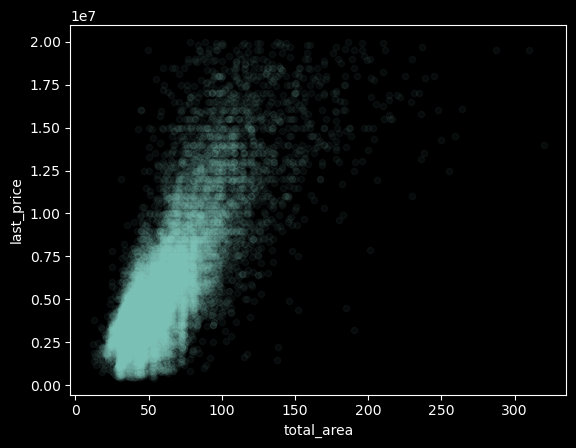

In [73]:
df[df['last_price']<20e6].plot(x='total_area', y='last_price', kind='scatter', grid=False, alpha =0.05);

сложно что-то понять, применим разбивку данных на диапазоны и группировку

In [74]:
df['total_area_group'] = pd.qcut(df['total_area'],10)

In [75]:
t=df.groupby('total_area_group',dropna=False)['last_price'].agg(['count','mean','median']).reset_index(drop=False)
t

,total_area_group,count,mean,median
0,"(11.999, 33.0]",2549,2.893505e+06,2990000.0
1,"(33.0, 37.6]",2202,3.447632e+06,3500000.0
2,"(37.6, 42.0]",2391,3.903906e+06,3900000.0
3,"(42.0, 46.0]",2574,3.941896e+06,3950000.0
4,"(46.0, 52.0]",2226,4.532126e+06,4500000.0
5,"(52.0, 58.0]",2343,4.891063e+06,4900000.0
6,"(58.0, 64.825]",2288,5.504853e+06,5250000.0
7,"(64.825, 75.0]",2493,6.760218e+06,6500000.0
8,"(75.0, 93.6]",2249,8.799258e+06,8000000.0
9,"(93.6, 900.0]",2361,2.100319e+07,14000000.0


<AxesSubplot:>

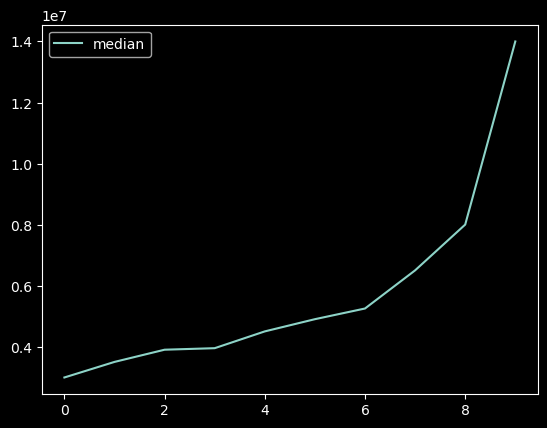

In [76]:
t.plot(y='median')

на графике виден рост медианной цены в зависимости от общей площади

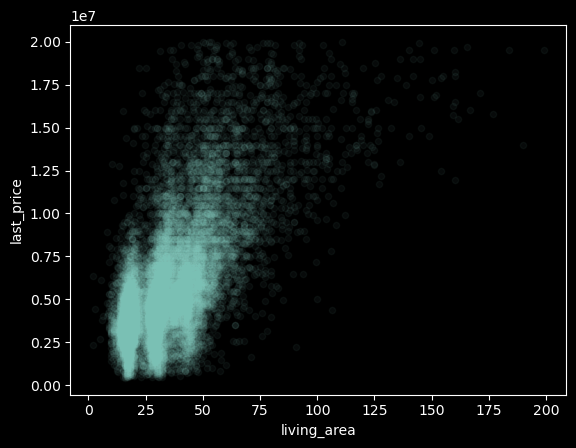

In [77]:
df[df['last_price']<20e6].plot(x='living_area', y='last_price', kind='scatter', grid=False, alpha =0.05);

также применним разбивку данных на диапазоны и группировку

In [78]:
df['living_area_group'] = pd.qcut(df['living_area'],10)

In [79]:
l=df.groupby('living_area_group',dropna=False)['last_price'].agg(['count','mean','median']).reset_index(drop=False)
l

,living_area_group,count,mean,median
0,"(1.999, 16.4]",2227,3.626854e+06,3400000.0
1,"(16.4, 18.0]",2770,3.450109e+06,3350000.0
2,"(18.0, 20.0]",1705,4.009364e+06,3870000.0
3,"(20.0, 27.5]",2015,4.472268e+06,4200000.0
4,"(27.5, 30.0]",2297,4.289091e+06,4099000.0
5,"(30.0, 33.428]",2051,5.166864e+06,4850000.0
6,"(33.428, 39.6]",2186,6.494724e+06,5650000.0
7,"(39.6, 45.0]",2248,6.237559e+06,5600000.0
8,"(45.0, 55.0]",2137,8.229250e+06,7200000.0
9,"(55.0, 409.7]",2139,1.952733e+07,12980000.0


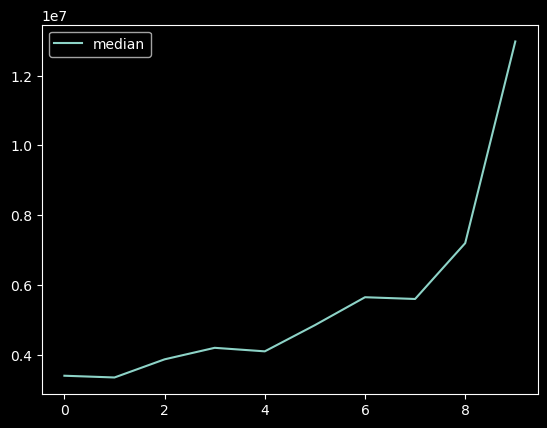

In [80]:
l.plot(y='median');

как и в случае зависимости от общей площади на графике виден рост медианной цены в зависимости от жилой площади

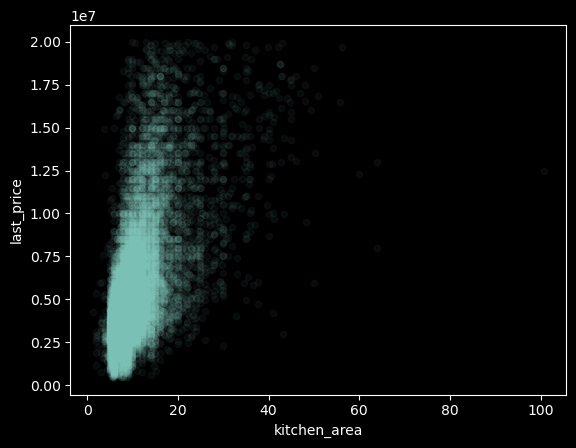

In [81]:
df[df['last_price']<20e6].plot(x='kitchen_area', y='last_price', kind='scatter', grid=False, alpha =0.05);

применим разбивку данных на диапазоны и группировку

In [82]:
df['kitchen_area_group'] = pd.cut(df['kitchen_area'],[1,10,20,30,40,50, float('inf')])

In [83]:
k=df.groupby('kitchen_area_group',dropna=False)['last_price'].agg(['count','mean','median']).reset_index(drop=False)
k

,kitchen_area_group,count,mean,median
0,"(1.0, 10.0]",12935,4.369188e+06,4000000.0
1,"(10.0, 20.0]",7444,7.991514e+06,6276055.0
2,"(20.0, 30.0]",700,1.842947e+07,12195000.0
3,"(30.0, 40.0]",192,2.859335e+07,17518500.0
4,"(40.0, 50.0]",85,3.130479e+07,20500000.0
5,"(50.0, inf]",46,6.374538e+07,40950000.0


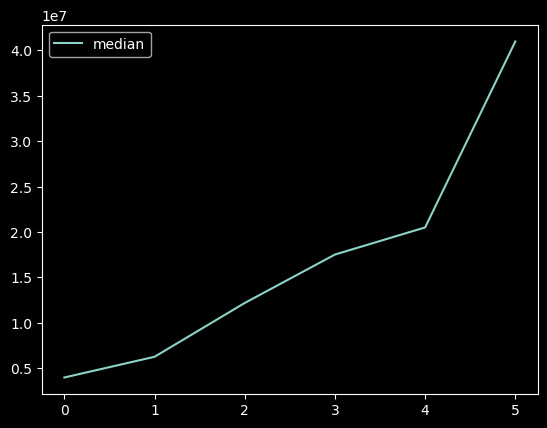

In [84]:
k.plot(y='median');

чем больше площадь кухни, тем выше цена объекта

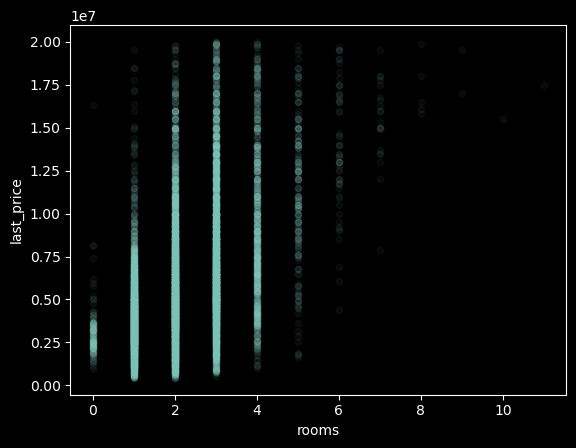

In [85]:
df[df['last_price']<20e6].plot(x='rooms', y= 'last_price', kind='scatter', grid=False, alpha =0.05);

In [86]:
price_rooms_dep = df.groupby('rooms',dropna=False)['last_price'].agg(['count','mean','median']).reset_index(drop=False)
price_rooms_dep

,rooms,count,mean,median
0,0,197,3.337724e+06,2700000.0
1,1,8036,3.834810e+06,3600000.0
2,2,7934,5.594539e+06,4772669.0
3,3,5809,8.181046e+06,6200000.0
4,4,1179,1.333395e+07,9000000.0
5,5,326,2.376208e+07,14000000.0
6,6,105,3.170975e+07,19000000.0
7,7,59,5.147007e+07,24900000.0
8,8,12,5.022417e+07,23095000.0
9,9,8,3.415236e+07,23750000.0


In [87]:
price_rooms_dep['count'].sum() #проверяю, что ничего не потеряно после группировки

23676

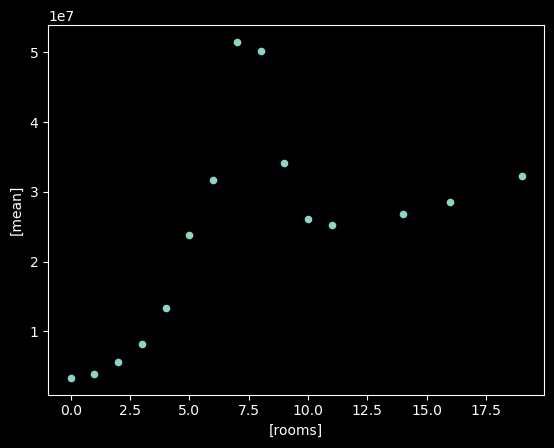

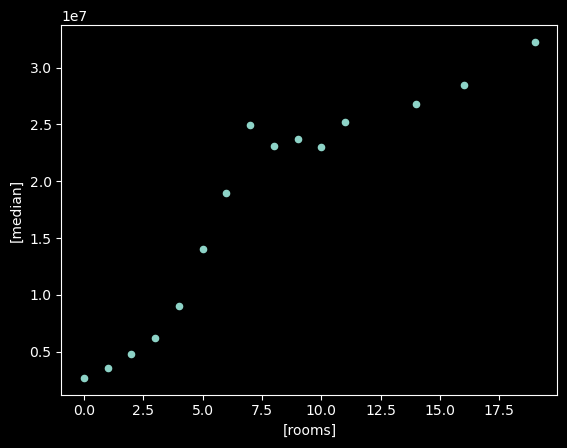

In [88]:
price_rooms_dep[price_rooms_dep['mean']<6e7].plot(x=['rooms'], y=['mean'], kind='scatter', grid=False, alpha =1)

price_rooms_dep[price_rooms_dep['median']<4e7].plot(x=['rooms'], y=['median'], kind='scatter', grid=False, alpha =1);

средняя и медианная цены возрастают с увеличением количества комнат.
Для квартир, в которых более 5 комнат статистика уже небольшая и среднее значение цены сильно скачет, а медианное равномерно растет 

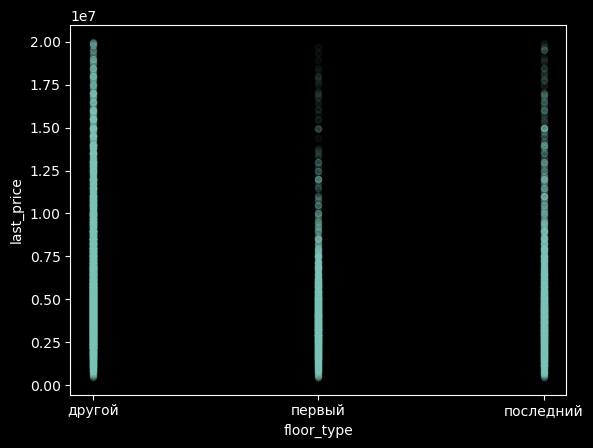

In [89]:
df[df['last_price']<20e6].plot(x='floor_type', y= 'last_price', kind='scatter', grid=False, alpha =0.05);

In [90]:
ft = df.groupby('floor_type',dropna=False)['last_price'].agg(['count','mean','median']).reset_index(drop=False)
ft

,floor_type,count,mean,median
0,другой,17431,6.677258e+06,4850000.0
1,первый,2913,4.806002e+06,3900000.0
2,последний,3332,7.332355e+06,4300000.0


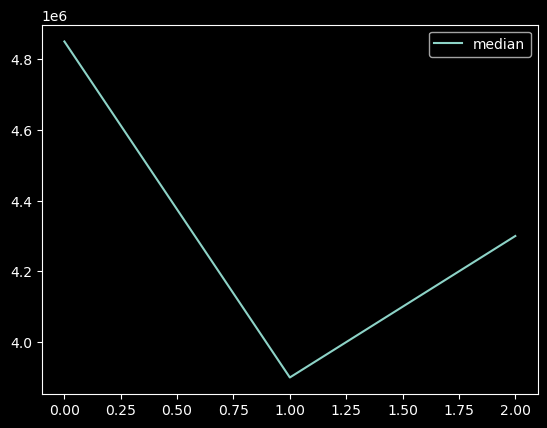

In [91]:
ft.plot(y='median');

первый и последний этажи ценятся ниже чем остальные

In [92]:
we = df.groupby('weekday_exposition',dropna=False)['last_price'].agg(['count','mean','median']).reset_index(drop=False)
we

,weekday_exposition,count,mean,median
0,0,3609,6.483050e+06,4650000.0
1,1,4178,6.394681e+06,4725000.0
2,2,3970,6.630625e+06,4700000.0
3,3,4291,6.712284e+06,4650000.0
4,4,3997,6.373761e+06,4580000.0
5,5,1935,6.977671e+06,4550000.0
6,6,1696,6.252689e+06,4550000.0


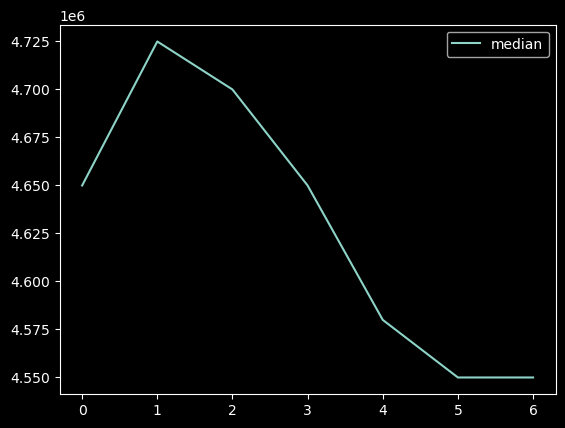

In [93]:
we.plot(y='median');

во вторник цена на объект выше всего, как мы помним и самих объявлений публикуется больше чем в другие дни, кроме четверга. далее в течение недели цена снижается, а вс остается на уровне сб

In [94]:
me = df.groupby('month_exposition',dropna=False)['last_price'].agg(['count','mean','median']).reset_index(drop=False)
me

,month_exposition,count,mean,median
0,1,1500,6.668233e+06,4600000.0
1,2,2638,6.469841e+06,4650000.0
2,3,2584,6.364909e+06,4660000.0
3,4,2379,6.737198e+06,4800000.0
4,5,1272,6.605114e+06,4515000.0
5,6,1758,6.312528e+06,4400000.0
6,7,1691,6.582689e+06,4650000.0
7,8,1742,6.353419e+06,4570000.0
8,9,1980,6.826241e+06,4700000.0
9,10,2123,6.240213e+06,4570000.0


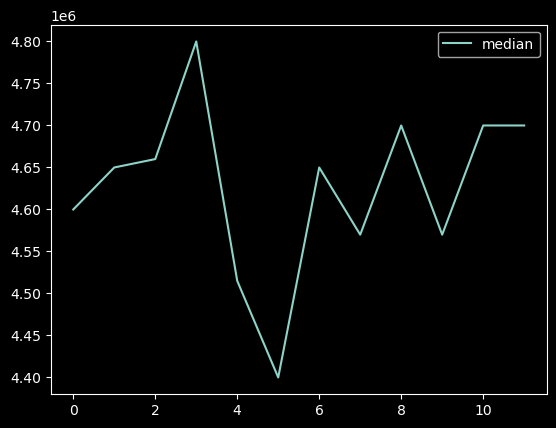

In [95]:
me.plot(y='median');

пик цен приходится на март, далее до мая цены падают, за летние месяцы примерно устанавливается уровень, сохраняющийся до февраля

In [96]:
ye = df.groupby('year_exposition',dropna=False)['last_price'].agg(['count','mean','median']).reset_index(drop=False)
ye

,year_exposition,count,mean,median
0,2014,137,1.208714e+07,7700000.0
1,2015,1190,8.575542e+06,5350000.0
2,2016,2782,6.828354e+06,4550000.0
3,2017,8183,6.574460e+06,4500000.0
4,2018,8507,5.953542e+06,4550000.0
5,2019,2877,6.784732e+06,5050000.0


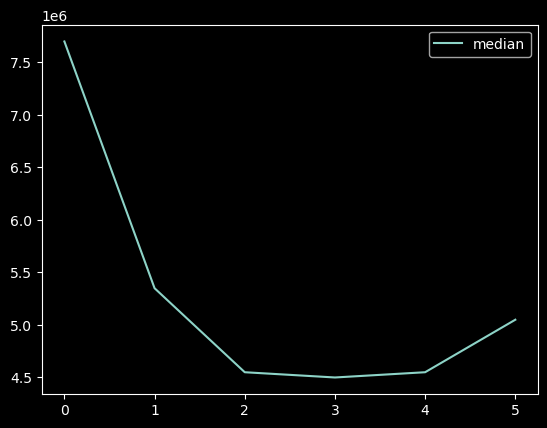

In [97]:
ye.plot(y='median');

резкое падение с 2014 по 2015 год, скорее всего, связано с малой статистикой, с 2016 по 2018 цены практически не менялись, в 2019 наблюдался рост, посмотрим на график, исключив данные за 2014 год

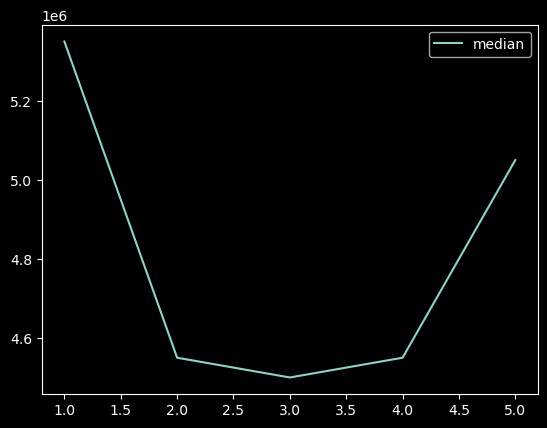

In [98]:
ye[ye['year_exposition']>2014].plot(y='median');

видно, что в 2019 году цены приблизились к уровню 2015 года

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [99]:
ln = df.groupby('locality_name',dropna=False)['sqm_price'].agg(['count','mean']).reset_index(drop=False).sort_values('count', ascending = False)

ln.head(10)

,locality_name,count,mean
34,Санкт-Петербург,15710,114798.212859
204,посёлок Мурино,556,85681.762601
263,посёлок Шушары,440,78677.364217
4,Всеволожск,397,68719.320400
33,Пушкин,369,103125.819291
14,Колпино,338,75424.579098
211,посёлок Парголово,327,90175.913458
7,Гатчина,307,68746.146763
80,деревня Кудрово,299,92473.547576
5,Выборг,235,58238.143141


Самая высокая цена была в Петербурге, Пушкине и Кудрово.

Самая низкая - в Выборге, Всеволжске и Гатчине

Выделим квартиры в Санкт-Петербурге и вычислим среднюю цену при удалении от центра с шагом в 1 км.

In [100]:
spb = df[df['locality_name'] == 'Санкт-Петербург']
len(spb)

15710

In [101]:
spb['cityCenters_nearest_km'].describe()

count    15649.000000
mean        11.595821
std          4.864305
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         29.000000
Name: cityCenters_nearest_km, dtype: float64

пропусков мало, почти все значения в столбце заполнены

сделаем группировку по удалению от центра

и найдём среднюю цену

In [102]:
spb['cityCenters_nearest_group'] = pd.cut(spb['cityCenters_nearest_km'], 29)

t = spb.groupby('cityCenters_nearest_group')['sqm_price'].agg(['count','mean']).reset_index(drop=False)
t

,cityCenters_nearest_group,count,mean
0,"(-0.029, 1.0]",219,185491.066628
1,"(1.0, 2.0]",310,157849.007329
2,"(2.0, 3.0]",350,121387.453704
3,"(3.0, 4.0]",688,133282.874761
4,"(4.0, 5.0]",920,140509.789046
5,"(5.0, 6.0]",617,150228.861102
6,"(6.0, 7.0]",420,156176.879664
7,"(7.0, 8.0]",595,124851.350368
8,"(8.0, 9.0]",593,113319.444993
9,"(9.0, 10.0]",719,112727.516925


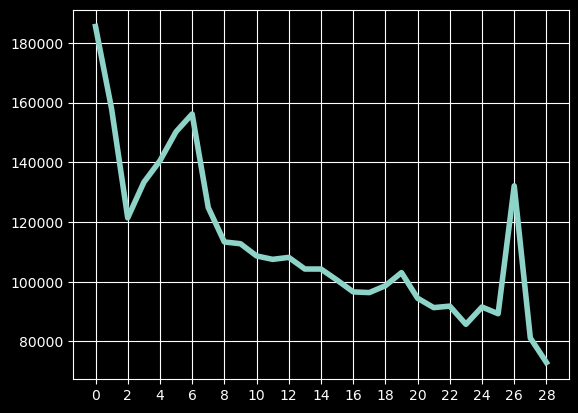

In [103]:
t.plot(y='mean', grid=True, xticks=range(0,30,2), linewidth=4, legend=False);

после 17 км статистика недостаточная, этот участок можно не рассматривать
с 0 до 3 также небольшая выборка данных, поэтому есть перепады на диаграмме

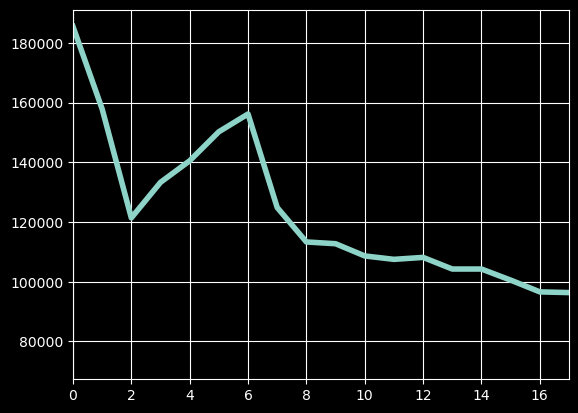

In [104]:
t.plot(y='mean', grid=True, xticks=range(0,17,2), linewidth=4, legend=False, xlim=[0,17]);

средняя цена квадратного метра снижается при удалении от центра
резкое увеличение цены с 2 до 7 км связано с тем, что это расстояние включает весь центр, а также Петроградский и Васильевский острова

### Общий вывод

Целью работы было выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.

В ходе выполнения работы была проведена предобработка входных данных:
1. заполнены пропуски в столбцах
- is_apartment
- balcony
- ceiling_height

2. с помощь цикла и вручную удалены выбросы, опечатки и дубликаты в столбцах
- ceiling_height
- locality_name

3. применена разбивка данных на диапазоны и группировка по различным категориям, добавлены новые столбцы, отображающие:
- день недели, месяц и год публикации объявления
- расстояние до центра в км
- категория этажа

4. проведена проверка на адекватность сильно выбивающихся значений в столбцах last_price, total_area, living_area, ceiling_height

В результате анализа полученных данных можно сделать следующие выводы:

1. большинство объектов недвижимости это 2-4 комнатные квартиры стоимость до 20 млн р и площадью 40-50 кв.м с высотой потолков от 2.5 до 3.1 м расположенные не на первом и не на последнем этажах

2. очень много квартир продается на 1-6 этажах, также есть группа с большим количеством объявлений на 7-10 этажах

3. число предложений о продаже сначала растет с увеличением расстояния до центра и достигает максимума при 5 км, далее идёт спад до 7-8 км (скорее всего, примерно на этом расстоянии располагаются пром.зоны), далее идёт рост (советская многоэтажная застройка,переходящая в многоэтажные новостройки), также наблюдается пик на расттоянии 30 км, это уже предложения за КАДом - города и новостройки в Лен. области. Также есть пик после 50 км. можно предположить, что это дачи и загородные дома

4. в большинстве случаев расстояние до ближайшего парка менее 1000 м

5. больше всего объявлений публикуется в четверг и во вторник, меньше всего - на выходных, при этом во вторник цена на объект самая высокая, далее в течение недели цена снижается, а вс остается на уровне сб; самые популярные месяцы размещения объявлений - февраль, март и апрель, в мае происходит просадка, в июне оживление и рост до ноября, в декабре и январе спад, пик цен приходится на март, далее до мая цены падают, за летние месяцы примерно устанавливается уровень, сохраняющийся до февраля  

6. в среднем объявление висит 180 дней, медианное значение - 95 дней, быстрыми продажами можно назвать продажи в течение 50 дней, бывают необычно долгие продажи - продажи дольше 1000 дней

7. сильнее всего цена квартиры зависит от общей площади, далее по убыванию: жилая площадь, площадь кухни и количество комнат, первый и последний этажи ценятся ниже чем остальные

8. в 2015 году цены на недвижимость были самые высокие, с 2016 по 2018 цены практически не менялись, в 2019 наблюдался рост и цены приблизились, но не достигли уровня 2015 года

9. самая высокая цена за квадратный метр была в Петербурге, Пушкине и Кудрово; самая низкая - в Выборге, Всеволжске и Гатчине

10. средняя цена за квадратный метр снижается при удалении от центра

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод